# Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [74]:
# Importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Histogram of Oriented Gradients (HOG)

### Feature extraction

Using built in `hog()` function from the scikit-image package 

Vehicle images: 8792
Non vehicle images: 8968


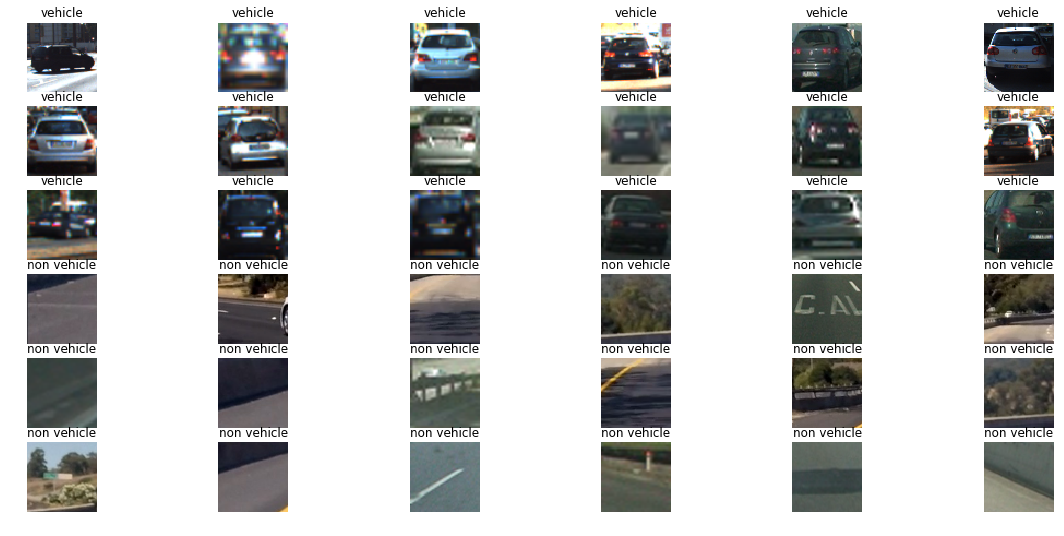

In [75]:
# Inspect the training samples
import glob
vehicle_images = glob.glob("training_images/vehicles/**/*.png")
nb_vehicle_images = len(vehicle_images)
non_vehicle_images = glob.glob("training_images/non-vehicles/**/*.png")
nb_non_vehicle_images = len(non_vehicle_images)

rows = 6
columns = 6

plt.figure(figsize=(20, 9))

for i, file in enumerate(np.random.choice(vehicle_images, 18)):
    plt.subplot(rows, columns, i + 1)
    plt.axis("off")
    plt.title("vehicle")
    plt.imshow(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB))

for i, file in enumerate(np.random.choice(non_vehicle_images, 18)):
    plt.subplot(rows, columns, i + 1 + 18)
    plt.axis("off")
    plt.title("non vehicle")   
    plt.imshow(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB))
    
print('Vehicle images: {}'.format(nb_vehicle_images))    
print('Non vehicle images: {}'.format(nb_non_vehicle_images))    

In [76]:
# Return the hog features with and optionaly a visualization
# This function is copied from the section 20 of the course
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False, block_norm='L2-Hys')
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec, block_norm='L2-Hys')
        return features

(-0.5, 63.5, 63.5, -0.5)

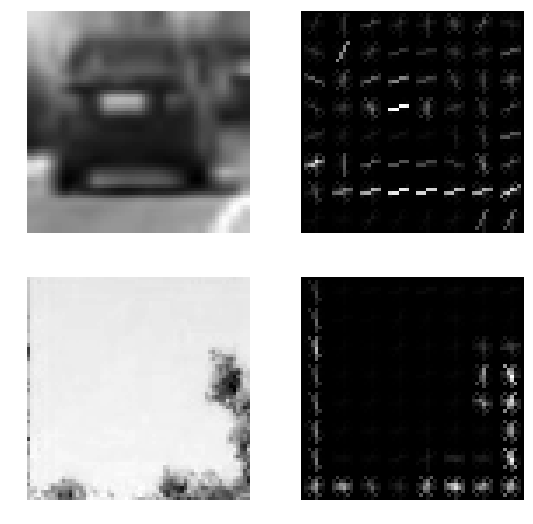

In [77]:
# Test HOG features
test_vehicle = cv2.imread(vehicle_images[0])
test_vehicle = cv2.cvtColor(test_vehicle, cv2.COLOR_RGB2GRAY)
test_non_vehicle = cv2.imread(non_vehicle_images[0])
test_non_vehicle = cv2.cvtColor(test_non_vehicle, cv2.COLOR_RGB2GRAY)

orient = 9
pix_per_cell = 8
cell_per_block = 2

_, vehicle_hog = get_hog_features(test_vehicle, orient, pix_per_cell, cell_per_block, vis = True)
_, non_vehicle_hog = get_hog_features(test_non_vehicle, orient, pix_per_cell, cell_per_block, vis = True)

plt.figure(figsize=(9, 9))

plt.subplot(2, 2, 1)
plt.imshow(test_vehicle, cmap="gray")
plt.axis("off")
plt.subplot(2, 2, 2)
plt.imshow(vehicle_hog, cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(test_non_vehicle, cmap="gray")
plt.axis("off")
plt.subplot(2, 2, 4)
plt.imshow(non_vehicle_hog, cmap="gray")
plt.axis("off")

In [78]:
### Training the classifier

In [79]:
# Extract features from a single image
# This function is copied from section 29 of the class
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=False, hist_feat=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        
        hog_features = single_img_features(image, cspace, orient=orient, hog_channel=hog_channel, 
                                           pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                           spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=True)
        
        features.append(hog_features)
    # Return list of feature vectors
    return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [80]:
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler

# colorspace can be one of Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# hog_channel can be one of 0, 1, 2, or "ALL"
# Adapted from the section 29 of the class

def train_svc(colorspace, hog_channel, orient = 9, pix_per_cell = 8, cell_per_block = 2,
              spatial_feat=False, hist_feat=False):
    
    train_size = min(nb_vehicle_images, nb_non_vehicle_images)

    cars = vehicle_images[0:train_size]
    notcars = non_vehicle_images[0:train_size]    
        
    car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat)
    notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat)

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    # Use a linear SVC 
    #svc = LinearSVC()
    # Use a SVC and tune parameter    
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
    svc = GridSearchCV(SVC(), parameters)
        
    # Check the training time for the SVC
    svc.fit(X_train, y_train)

    # Return the accuracy on the test partition
    return round(svc.score(X_test, y_test), 6), svc, X_scaler    

In [ ]:
# Checking all the combination of color spaces / channels all other params being fixed
# The idea being to select those 2 params before tuning others
# NOTE: using a single channel is best for performance

for color_space in ('RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb'):
    for channel in (0, 1, 2, 'ALL'):
        score, svc, X_scaler = train_svc(color_space, channel, spatial_feat=True, hist_feat=True)
        print('Score for channel {} of {} = {}'.format(channel, color_space, score))    
        
'''
Results (submission #1 using only 4000 training exemples):
Score for channel 0 of RGB = 0.95
Score for channel 1 of RGB = 0.93375
Score for channel 2 of RGB = 0.93375
Score for channel ALL of RGB = 0.960625
Score for channel 0 of HSV = 0.959375
Score for channel 1 of HSV = 0.9075
Score for channel 2 of HSV = 0.938125
Score for channel ALL of HSV = 0.99625
Score for channel 0 of LUV = 0.92375
Score for channel 1 of LUV = 0.90125
Score for channel 2 of LUV = 0.939375
Score for channel ALL of LUV = 0.9925
Score for channel 0 of HLS = 0.956875
Score for channel 1 of HLS = 0.95
Score for channel 2 of HLS = 0.89375
Score for channel ALL of HLS = 0.99625
Score for channel 0 of YUV = 0.943125
Score for channel 1 of YUV = 0.88875
Score for channel 2 of YUV = 0.946875
Score for channel ALL of YUV = 0.999375
Score for channel 0 of YCrCb = 0.93625
Score for channel 1 of YCrCb = 0.87125
Score for channel 2 of YCrCb = 0.92625
Score for channel ALL of YCrCb = 0.990625
'''     
 

'''
Current submission - using all training examples

1) HOG only (no color, no hist)
Score for channel 0 of RGB = 0.92124
Score for channel 1 of RGB = 0.918681
Score for channel 2 of RGB = 0.901336
Score for channel ALL of RGB = 0.932329
Score for channel 0 of HSV = 0.892522
Score for channel 1 of HSV = 0.903895
Score for channel 2 of HSV = 0.915837
Score for channel ALL of HSV = 0.945692
Score for channel 0 of LUV = 0.922377
Score for channel 1 of LUV = 0.887688
Score for channel 2 of LUV = 0.915269
Score for channel ALL of LUV = 0.966449
Score for channel 0 of HLS = 0.876599
Score for channel 1 of HLS = 0.916975
Score for channel 2 of HLS = 0.901336
Score for channel ALL of HLS = 0.943986
Score for channel 0 of YUV = 0.914416
Score for channel 1 of YUV = 0.888541
Score for channel 2 of YUV = 0.922661
Score for channel ALL of YUV = 0.965311
Score for channel 0 of YCrCb = 0.919249
Score for channel 1 of YCrCb = 0.87205
Score for channel 2 of YCrCb = 0.926358
Score for channel ALL of YCrCb = 0.967017

2) Adding color and  hist
Score for channel 0 of RGB = 0.978959
Score for channel 1 of RGB = 0.979812
Score for channel 2 of RGB = 0.975263
Score for channel ALL of RGB = 0.974979
Score for channel 0 of HSV = 0.97242
Score for channel 1 of HSV = 0.973557
Score for channel 2 of HSV = 0.981518
Score for channel ALL of HSV = 0.984646
Score for channel 0 of LUV = 0.98095
Score for channel 1 of LUV = 0.969292
Score for channel 2 of LUV = 0.981234
Score for channel ALL of LUV = 0.98493
Score for channel 0 of HLS = 0.967586
Score for channel 1 of HLS = 0.974694
Score for channel 2 of HLS = 0.972988
Score for channel ALL of HLS = 0.984646
Score for channel 0 of YUV = 0.978675
Score for channel 1 of YUV = 0.970998
Score for channel 2 of YUV = 0.974126
Score for channel ALL of YUV = 0.987205
Score for channel 0 of YCrCb = 0.98294
Score for channel 1 of YCrCb = 0.966449
Score for channel 2 of YCrCb = 0.978391
Score for channel ALL of YCrCb = 0.992039
'''

In [8]:
# 3) Tune SVC parameters
# -> Score for channel 0 of YCrCb = 0.994598

color_space = 'YCrCb'
channel = 0
score, svc, X_scaler = train_svc(color_space, channel, spatial_feat=True, hist_feat=True)
print('Score for channel {} of {} = {}'.format(channel, color_space, score))

Score for channel 0 of YCrCb = 0.992607


In [10]:
from sklearn.externals import joblib

# Save the model
model = {
    'svc': svc,
    'scaler': X_scaler,    
}

joblib.dump(model, 'model.pkl') 

# Restore with
# model = joblib.load('model.pkl')

['model.pkl']

In [ ]:
# We will use the H channel of HSL: Score for channel 0 of HLS = 0.956875
# Check if tuning the other parameters is helpful
for orient in (8, 9, 10):
    for pix_per_cell in (6, 8, 10):
        for cell_per_block in (1, 2):
            score, svc, X_scaler = train_svc('YCrCb', 0, 
                                             orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,  
                                             spatial_feat=False, hist_feat=False)
            print('orient {} pix_per_cell {} cell_per_block {} -> {}'.format(orient, pix_per_cell, cell_per_block, score)) 
            
'''
Results (submission #1 using only 4000 training exemples):
orient 8 pix_per_cell 6 cell_per_block 1 -> 0.9575
orient 8 pix_per_cell 6 cell_per_block 2 -> 0.954375
orient 8 pix_per_cell 8 cell_per_block 1 -> 0.95875
orient 8 pix_per_cell 8 cell_per_block 2 -> 0.9525
orient 8 pix_per_cell 10 cell_per_block 1 -> 0.953125
orient 8 pix_per_cell 10 cell_per_block 2 -> 0.9525
orient 9 pix_per_cell 6 cell_per_block 1 -> 0.955625
orient 9 pix_per_cell 6 cell_per_block 2 -> 0.946875
orient 9 pix_per_cell 8 cell_per_block 1 -> 0.954375
orient 9 pix_per_cell 8 cell_per_block 2 -> 0.9525
orient 9 pix_per_cell 10 cell_per_block 1 -> 0.9525
orient 9 pix_per_cell 10 cell_per_block 2 -> 0.9575
orient 10 pix_per_cell 6 cell_per_block 1 -> 0.96
orient 10 pix_per_cell 6 cell_per_block 2 -> 0.94875
orient 10 pix_per_cell 8 cell_per_block 1 -> 0.941875
orient 10 pix_per_cell 8 cell_per_block 2 -> 0.9575
orient 10 pix_per_cell 10 cell_per_block 1 -> 0.9575
orient 10 pix_per_cell 10 cell_per_block 2 -> 0.950625

New submission
'''

## Finding car on a still image

### Sliding window search

In [82]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=2):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a single function that can extract features using hog sub-sampling and make predictions
# This function is adapted from the section 35 of the course to used the previsouly tuned HOG params 
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size=(32, 32), hist_bins=32):
    
    rectangles = []   
    rectangles_found = []
    #img = img.astype(np.float32)/255    
    img_tosearch = img[ystart:ystop,:,:]
    
    ctrans_tosearch = np.copy(img_tosearch)

    # Convert color space
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else:
        ctrans_tosearch = np.copy(img_tosearch) 
        
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # Select HOG channel 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]
        
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
                            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                
            test_prediction = svc.predict(test_features)          
        
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            
            rect = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))            
            rectangles.append(rect)
        
            if test_prediction == 1:
                rectangles_found.append(rect)
                
    return rectangles, rectangles_found


In [83]:
# Quick check on still images

color_space = 'YCrCb'
hog_channel = 0        
orient = 9
pix_per_cell = 8
cell_per_block = 2

score, svc, X_scaler = train_svc(color_space, hog_channel, orient, pix_per_cell, cell_per_block,
                                spatial_feat=True, hist_feat=True)        

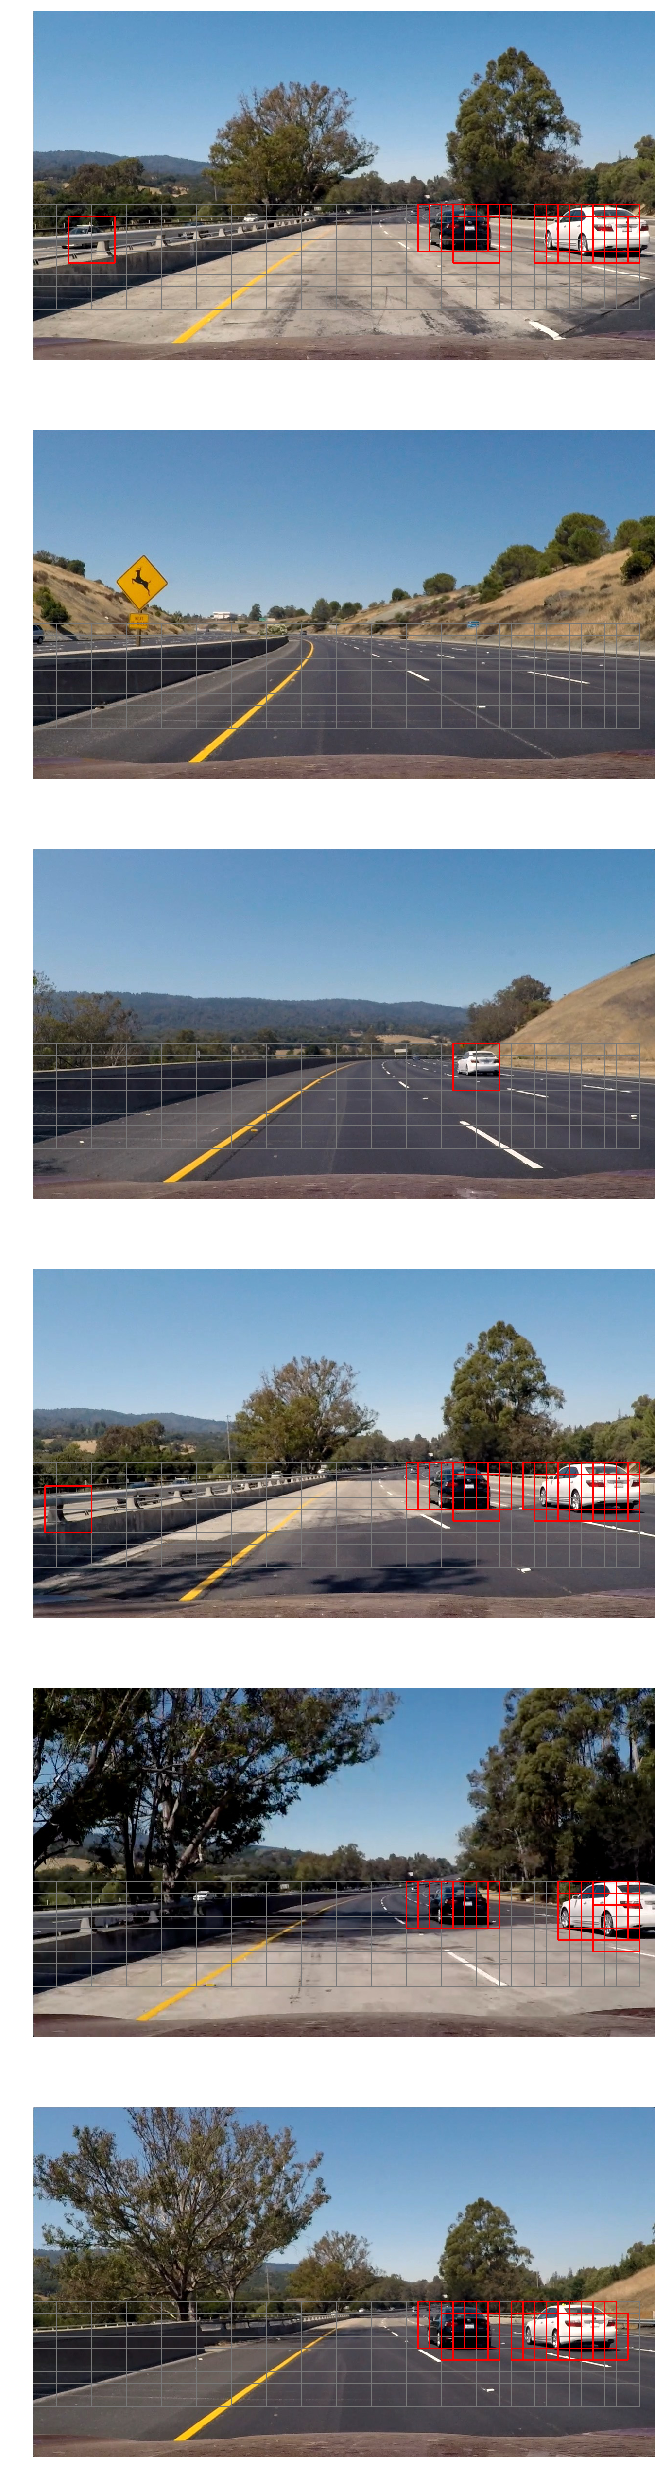

In [84]:
ystart = 400
ystop = 656
scale = 1.5

rows = 6
columns = 1

plt.figure(figsize=(40, 45))

for i in [1, 2, 3, 4, 5, 6]:
    img = cv2.imread('test_images/test{}.jpg'.format(i))
    rectangles, rectangles_found = find_cars(img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    plt.subplot(rows, columns, i)
    plt.axis("off")
    img = draw_boxes(img, rectangles, (120, 120, 120), 1)
    img = draw_boxes(img, rectangles_found)    
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

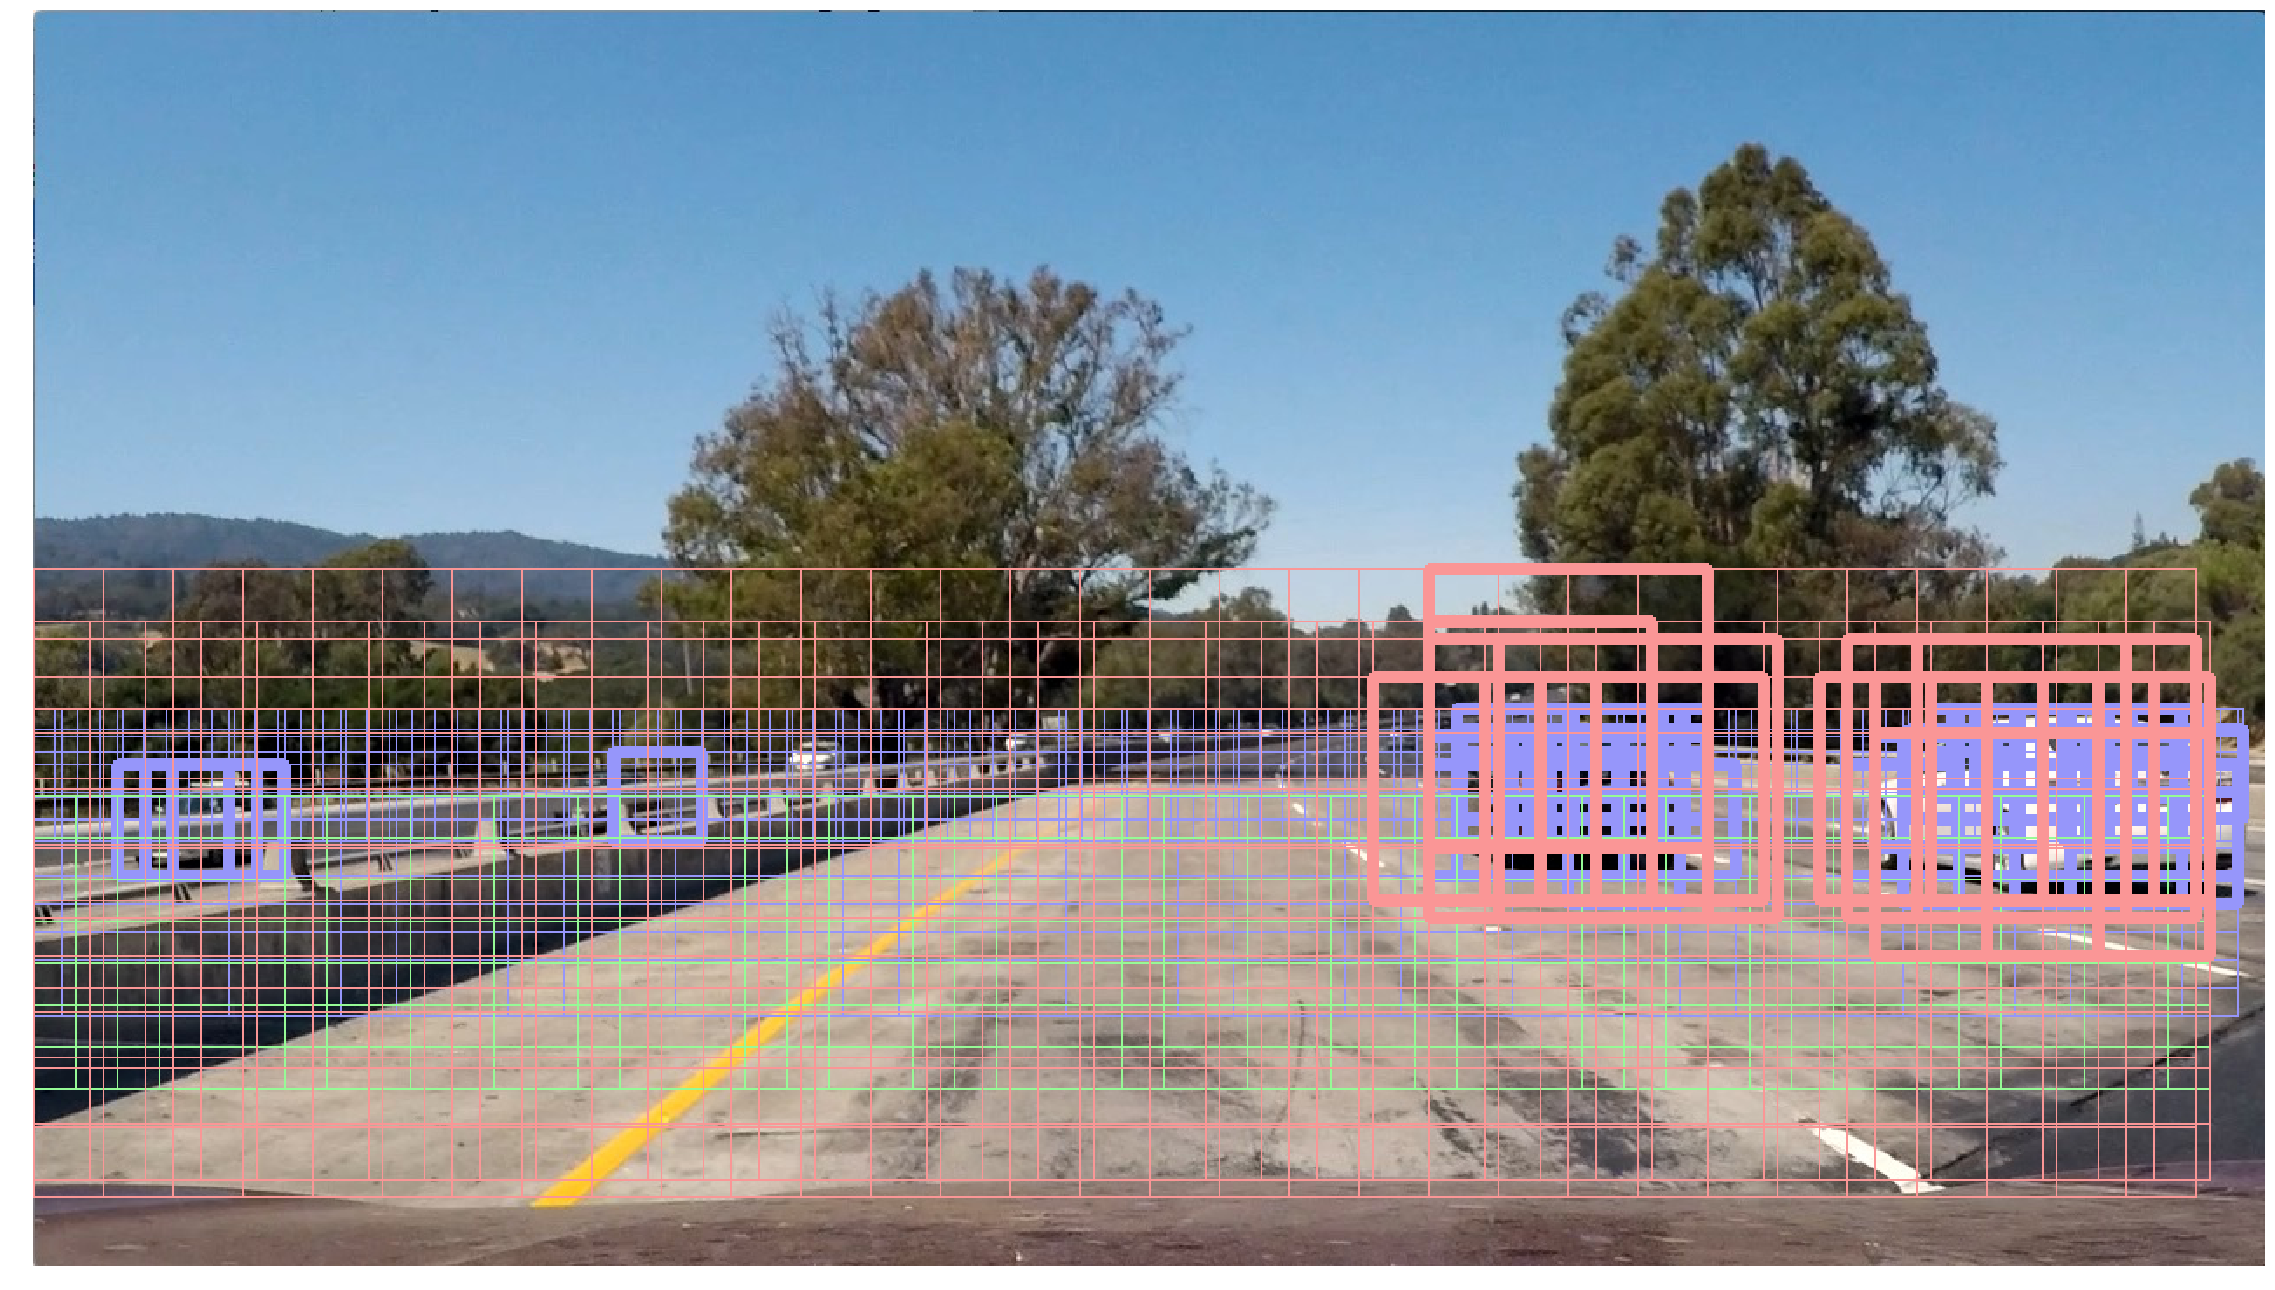

In [85]:
# Tune the parameters for the bounding box size
# The larger the car should be the larger the bounding box

img = cv2.imread('test_images/test1.jpg')

out_img = img.copy()

bboxes = []

# Scale 0.8
ystart = 400
ystop = 500
scale = 0.8
rectangles, rectangles_found = find_cars(img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block)
out_img = draw_boxes(out_img, rectangles, (250, 150, 150), 1)
out_img = draw_boxes(out_img, rectangles_found, (250, 150, 150), 6)
bboxes = bboxes + rectangles_found

# Scale 1
ystart = 400
ystop = 600
scale = 1
rectangles, rectangles_found = find_cars(img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block)
out_img = draw_boxes(out_img, rectangles, (250, 150, 150), 1)
out_img = draw_boxes(out_img, rectangles_found, (250, 150, 150), 6)
bboxes = bboxes + rectangles_found

# Scale 1.5
ystart = 450
ystop = 650
scale = 1.5
rectangles, rectangles_found = find_cars(img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block)
out_img = draw_boxes(out_img, rectangles, (150, 250, 150), 1)
out_img = draw_boxes(out_img, rectangles_found, (150, 250, 150), 6)
bboxes = bboxes + rectangles_found

# Scale 2
ystart = 350
ystop = 720
scale = 2
rectangles, rectangles_found = find_cars(img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block)
out_img = draw_boxes(out_img, rectangles, (150, 150, 250), 1)
out_img = draw_boxes(out_img, rectangles_found, (150, 150, 250), 6)
bboxes = bboxes + rectangles_found

# Scale 2.5
ystart = 320
ystop = 720
scale = 2.5
rectangles, rectangles_found = find_cars(img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block)
out_img = draw_boxes(out_img, rectangles, (150, 150, 250), 1)
out_img = draw_boxes(out_img, rectangles_found, (150, 150, 250), 6)
bboxes = bboxes + rectangles_found

plt.figure(figsize=(40, 45))    
plt.axis("off")    
plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))

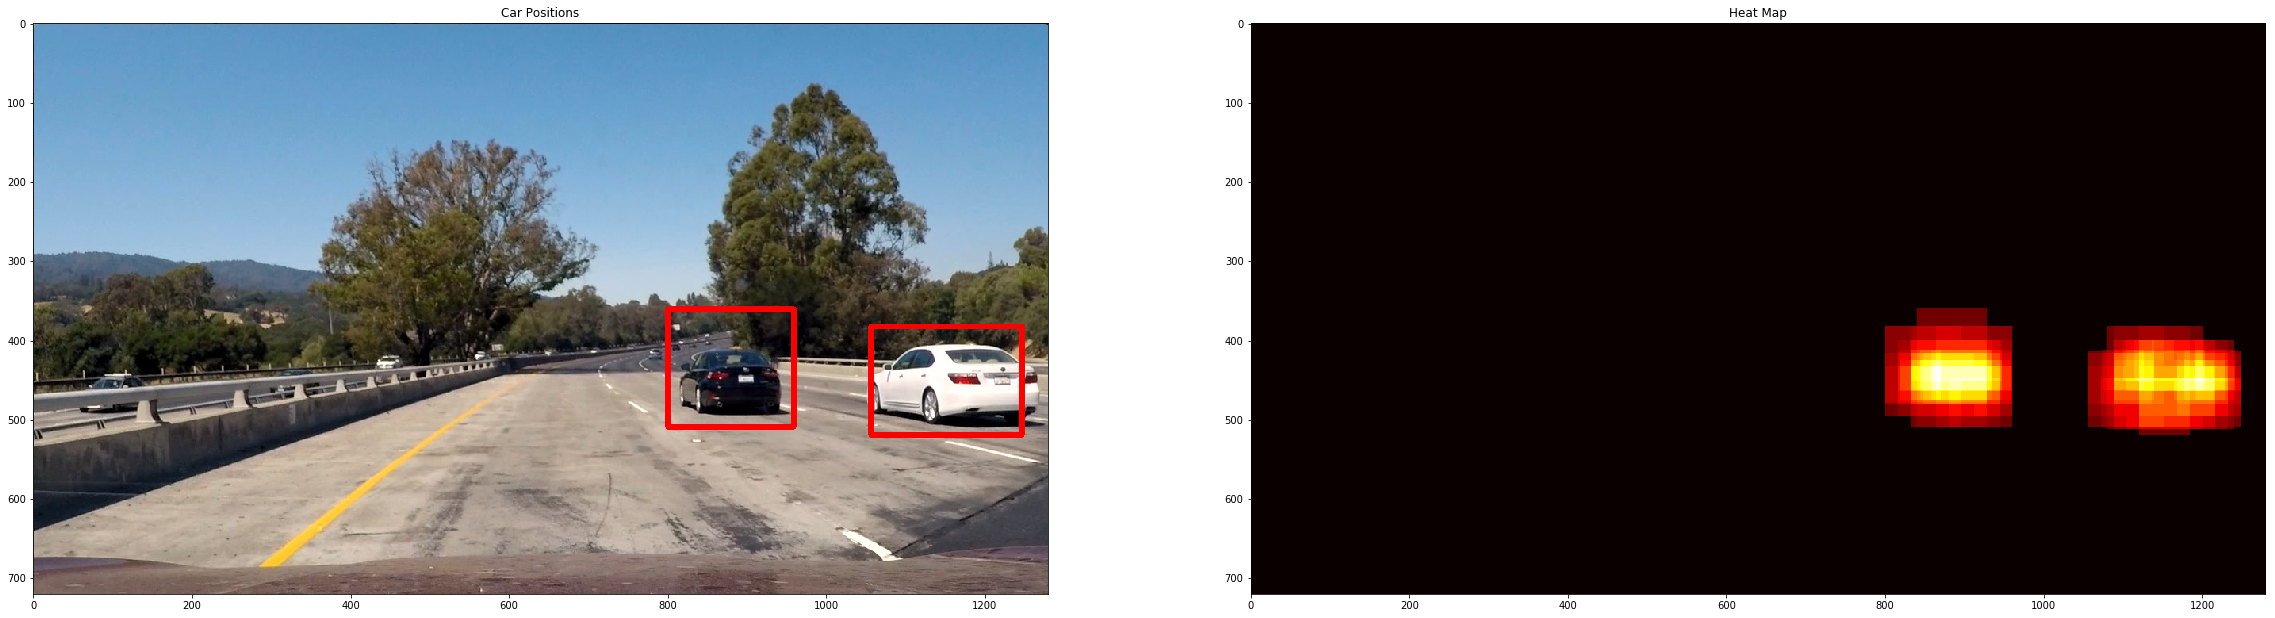

In [86]:
# Reduce/elimate false positive
# Use the heatmap solution described in the course

from scipy.ndimage.measurements import label

# Read in image similar to one shown above 
img = cv2.imread('test_images/test1.jpg')
heat = np.zeros_like(img[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat, bboxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

plt.figure(figsize=(40, 45))
plt.subplot(121)
plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')


In [91]:
# Pipeline for video
def process_image(img):
    bboxes = []
    
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Scale 0.8    
    ystart = 400
    ystop = 500
    scale = 0.8
    rectangles, rectangles_found = find_cars(rgb_img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    bboxes = bboxes + rectangles_found
    
    # Scale 1
    ystart = 400
    ystop = 600
    scale = 1
    rectangles, rectangles_found = find_cars(rgb_img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    bboxes = bboxes + rectangles_found

    # Scale 1.5
    ystart = 400
    ystop = 650
    scale = 1.5
    rectangles, rectangles_found = find_cars(rgb_img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    bboxes = bboxes + rectangles_found

    # Scale 2
    ystart = 350
    ystop = 720
    scale = 2
    rectangles, rectangles_found = find_cars(rgb_img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    bboxes = bboxes + rectangles_found

    # Scale 2.5
    ystart = 350
    ystop = 720
    scale = 2.5
    rectangles, rectangles_found = find_cars(rgb_img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    bboxes = bboxes + rectangles_found
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat, bboxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 5)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    return draw_labeled_bboxes(img.copy(), labels)

In [92]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Process the test video
video_output = "output_images/2-test_video.mp4"
clip1 = VideoFileClip("test_video.mp4")
clip1_output = clip1.fl_image(process_image)
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/2-test_video.mp4
[MoviePy] Writing video output_images/2-test_video.mp4


 97%|█████████▋| 38/39 [11:36<00:18, 18.55s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/2-test_video.mp4 

CPU times: user 11min 34s, sys: 2.21 s, total: 11min 36s
Wall time: 11min 37s


In [93]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [94]:
video_output = "output_images/2-project_video.mp4"
clip1 = VideoFileClip("project_video.mp4")
clip1_output = clip1.fl_image(process_image)
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/2-project_video.mp4
[MoviePy] Writing video output_images/2-project_video.mp4


100%|█████████▉| 1260/1261 [6:35:36<00:17, 17.84s/it]  


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/2-project_video.mp4 

CPU times: user 6h 34min 5s, sys: 1min 21s, total: 6h 35min 27s
Wall time: 6h 35min 37s


In [95]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))